In [327]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('train_dataset.csv')

In [328]:
import numpy as np

names_train = ['features_countvec/train_countvec_features_actor_1_name.npy', 'features_countvec/train_countvec_features_actor_2_name.npy', 
               'features_countvec/train_countvec_features_director_name.npy', 'features_doc2vec/train_doc2vec_features_genre.npy',
               'features_doc2vec/train_doc2vec_features_plot_keywords.npy', 'features_fasttext/train_fasttext_title_embeddings.npy']

for name in names_train:
    print(name)
    print(len(np.load(name)[0]))

features_countvec/train_countvec_features_actor_1_name.npy
2063
features_countvec/train_countvec_features_actor_2_name.npy
2919
features_countvec/train_countvec_features_director_name.npy
2113
features_doc2vec/train_doc2vec_features_genre.npy
100
features_doc2vec/train_doc2vec_features_plot_keywords.npy
100
features_fasttext/train_fasttext_title_embeddings.npy
100


In [329]:
def create_columns(len, unique):
    columns = []
    for i in range(len):
        columns.append(str(i + unique))
    return columns

In [330]:
temp1 = np.load('features_countvec/train_countvec_features_actor_1_name.npy')
df_act_1 = pd.DataFrame(temp1, columns=create_columns(len(temp1[0]), 0))

temp2 = np.load('features_countvec/train_countvec_features_actor_2_name.npy')
df_act_2 = pd.DataFrame(temp2, columns=create_columns(len(temp2[0]), len(temp1[0])))

temp3 = np.load('features_countvec/train_countvec_features_director_name.npy')
df_dir = pd.DataFrame(temp3, columns=create_columns(len(temp3[0]), len(temp1[0]) + len(temp2[0])))

temp4 = np.load('features_doc2vec/train_doc2vec_features_genre.npy')
df_genre = pd.DataFrame(temp4, columns=create_columns(len(temp4[0]), len(temp1[0]) + len(temp2[0]) + 100))

temp5 = np.load('features_doc2vec/train_doc2vec_features_plot_keywords.npy')
df_keyword = pd.DataFrame(temp5, columns=create_columns(len(temp5[0]), len(temp1[0]) + len(temp2[0]) + 200))

temp6 = np.load('features_fasttext/train_fasttext_title_embeddings.npy')
df_title = pd.DataFrame(temp6, columns=create_columns(len(temp6[0]), len(temp1[0]) + len(temp2[0]) + 300))

In [331]:
df_list = [df_act_1, df_act_2, df_dir, df_genre, df_keyword, df_title]
pre_data = pd.concat(df_list, axis=1)

data_new = pd.concat([data, pre_data], axis=1)

In [332]:
X_train, X_test, y_train, y_test = train_test_split(data_new.drop(columns='imdb_score_binned'), data_new['imdb_score_binned'], test_size=0.2, random_state=42)
#X_train = X_train.reset_index()
#X_test = X_test.reset_index()
#y_train = y_train.reset_index()
#y_test = y_test.reset_index()

In [333]:
X_train['country'].value_counts()

country
USA              1919
UK                202
France             64
Germany            52
Canada             36
Australia          26
Spain              17
Hong Kong           9
New Zealand         9
Japan               6
Italy               6
Denmark             6
China               5
South Korea         5
Ireland             4
Mexico              4
South Africa        3
Thailand            3
Brazil              2
Romania             2
Norway              2
Argentina           2
Russia              2
India               2
Netherlands         2
Belgium             1
Iran                1
Aruba               1
Hungary             1
Finland             1
Poland              1
Taiwan              1
Official site       1
West Germany        1
Israel              1
Chile               1
New Line            1
Iceland             1
Name: count, dtype: int64

In [334]:
X_train['language'].value_counts()

language
English       2308
French          25
Spanish         14
German           8
Mandarin         5
Cantonese        5
Italian          4
Danish           3
Japanese         3
Thai             2
Aboriginal       2
Korean           2
Portuguese       2
Norwegian        2
Dutch            2
Hindi            2
Kazakh           1
Maya             1
Arabic           1
Aramaic          1
Hebrew           1
Filipino         1
Mongolian        1
Romanian         1
Hungarian        1
Zulu             1
Bosnian          1
Persian          1
Dari             1
Name: count, dtype: int64

In [335]:
train_pre_data = X_train.iloc[:, 26:]

In [336]:
#from sklearn.decomposition import PCA
#PCs = [200, 400, 600, 800, 1000, 1500, 2000, 3000]
#var = []
#for n in PCs:

#    pca = PCA(n_components=n)

#    df_list = [df_act_1, df_act_2, df_dir, df_genre, df_keyword, df_title]
#    train_pre_data = pd.concat(df_list, axis=1)

#    columns = []
#    for i in range(n):
#        columns.append(str(i))

#    principalComponents = pca.fit_transform(train_pre_data)

#    var.append(np.var(principalComponents))
#import matplotlib.pyplot as plt
#cum_var = np.cumsum(var)

#plt.xlabel('Principal Components')
#plt.xlabel('Cumulative Explained Variance')
#plt.plot(PCs, cum_var)
#plt.show()

In [337]:
# Implement PCA to cut down columns further
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)

columns = []
for i in range(1000):
    columns.append(str(i))

principalComponents = pca.fit_transform(train_pre_data)

df_pca = pd.DataFrame(data=principalComponents, columns=columns)

In [338]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# Number of rows to reduce sparse matrices to
n=100

selector = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n, step=10)
X_train_RFE = selector.fit_transform(df_pca, y_train)

In [339]:
#from sklearn.feature_selection import RFECV
#from sklearn.tree import DecisionTreeClassifier

#selector = RFECV(estimator=DecisionTreeClassifier(), step=10, cv=5)
#selector.fit(df_pca, train['imdb_score_binned'])


#print(selector.n_features_)

In [340]:
columns = []
for i in range(n):
    columns.append(str(i))

df_selected_train = pd.DataFrame(data=X_train_RFE, columns=columns)

In [341]:
# Drop old columns and unnecessary columns
titles = ['actor_1_name', 'actor_2_name', 'director_name', 'genres', 'plot_keywords', 'language', 'country', 'id',
            'title_embedding', 'movie_title', 'actor_3_name', 'actor_3_facebook_likes']
df_temp = X_train.iloc[:, :26].drop(columns=titles)
train_new = pd.concat([df_temp.reset_index(), df_selected_train.reset_index()], axis=1)

In [342]:
X_train['content_rating'].value_counts()

content_rating
R            1102
PG-13         841
PG            355
G              52
Not Rated      21
Approved       10
Unrated        10
X               7
NC-17           2
M               1
Passed          1
GP              1
Name: count, dtype: int64

In [343]:
# Combine ratings
X_train.loc[X_train.content_rating == 'GP', 'content_rating'] = 'G'
X_train.loc[X_train.content_rating == 'Passed', 'content_rating'] = 'Approved'
X_train.loc[X_train.content_rating == 'NC-17', 'content_rating'] = 'X'
X_train.loc[X_train.content_rating == 'Not Rated', 'content_rating'] = 'Unrated'
X_train.loc[X_train.content_rating == 'M', 'content_rating'] = 'PG-13'

X_train['content_rating'].value_counts()

content_rating
R           1102
PG-13        842
PG           355
G             53
Unrated       31
Approved      11
X              9
Name: count, dtype: int64

In [344]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
encoded = enc.fit_transform(X_train[['content_rating']])

df_temp = pd.DataFrame(encoded.toarray(), columns=['Approved', 'G', 'PG', 'PG-13', 'R', 'Unrated', 'X'])

train_final = pd.concat([train_new.drop(columns=['content_rating']), df_temp], axis=1)

In [345]:
# Apply post processing, ie normalisation, standardisation
# Remove outliers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#scaler = MinMaxScaler()
scaler = StandardScaler()
X_norm = scaler.fit_transform(train_final)

In [346]:
test_pre_data = X_test.iloc[:, 26:]

In [347]:
# Apply fitted PCA to test data
test_pcs = pca.transform(test_pre_data)

columns = []
for i in range(1000):
    columns.append(str(i))

df_pca_test = pd.DataFrame(data=test_pcs, columns=columns)

In [348]:
X_test_RFE = selector.transform(df_pca_test)

In [349]:
columns = []
for i in range(n):
    columns.append(str(i))

df_selected_test = pd.DataFrame(data=X_test_RFE, columns=columns)

In [350]:
test_new = pd.concat([X_test.iloc[:, :26].drop(columns=titles).reset_index(), df_selected_test.reset_index()], axis=1)

print(len(test_new.columns))

116


In [351]:
# Combine ratings
X_test.loc[X_test.content_rating == 'GP', 'content_rating'] = 'G'
X_test.loc[X_test.content_rating == 'Passed', 'content_rating'] = 'Approved'
X_test.loc[X_test.content_rating == 'NC-17', 'content_rating'] = 'X'
X_test.loc[X_test.content_rating == 'Not Rated', 'content_rating'] = 'Unrated'
X_test.loc[X_test.content_rating == 'M', 'content_rating'] = 'PG-13'

encoded = enc.transform(X_test[['content_rating']])

df_temp = pd.DataFrame(encoded.toarray(), columns=['Approved', 'G', 'PG', 'PG-13', 'R', 'Unrated', 'X'])

test_new = pd.concat([test_new.drop(columns='content_rating'), df_temp], axis=1)

In [352]:
X_norm_test = scaler.transform(test_new)

In [353]:
from sklearn.ensemble import GradientBoostingClassifier

In [361]:
GTB = GradientBoostingClassifier(n_estimators=70, learning_rate=0.5,
                                 max_depth=5, random_state=0).fit(X_norm, y_train)
y_GTB = GTB.predict(X_norm_test)
df_GTB = pd.DataFrame(y_GTB, columns=['imdb_score_binned'])
df_GTB.insert(0, 'id', range(1, len(df_GTB) + 1))
df_GTB['imdb_score_binned'].value_counts()

imdb_score_binned
2    471
3    113
4     16
1      1
Name: count, dtype: int64

In [362]:
from sklearn.metrics import accuracy_score, f1_score
print(accuracy_score(y_test, y_GTB))
print(f1_score(y_test, y_GTB, average='macro'))

0.7138103161397671
0.3887196765498652


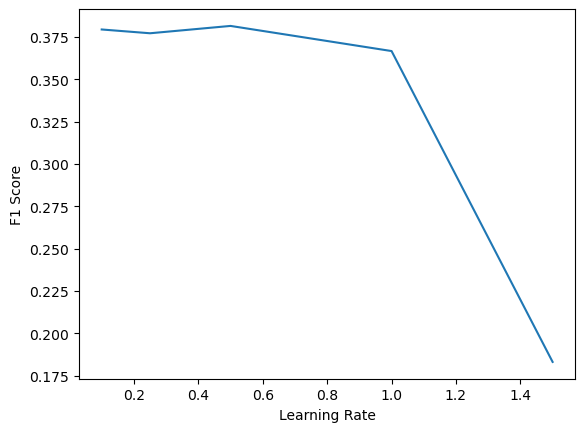

In [356]:
# Evaluate effectiveness of Gradient Boosting model
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score


learning_rate = [1.5, 1, 0.5, 0.25, 0.1]
y_pred_learning = []
for rate in learning_rate:
    model = GradientBoostingClassifier(learning_rate=rate).fit(X_norm, y_train)
    y_pred = model.predict(X_norm_test)
    y_pred_learning.append(f1_score(y_test, y_pred, average='macro'))

plt.plot(learning_rate, y_pred_learning)
plt.ylabel('F1 Score')
plt.xlabel('Learning Rate')
plt.show()

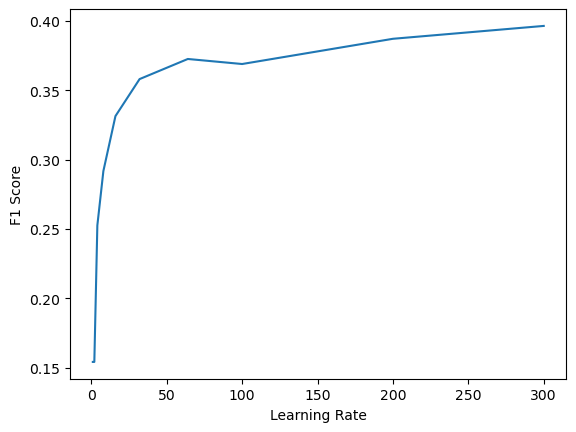

In [360]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 300]
y_pred_est = []
for n in n_estimators:
    model = GradientBoostingClassifier(n_estimators=n).fit(X_norm, y_train)
    y_pred = model.predict(X_norm_test)
    y_pred_est.append(f1_score(y_test, y_pred, average='macro'))

plt.plot(n_estimators, y_pred_est)
plt.ylabel('F1 Score')
plt.xlabel('n_estimators')
plt.show()

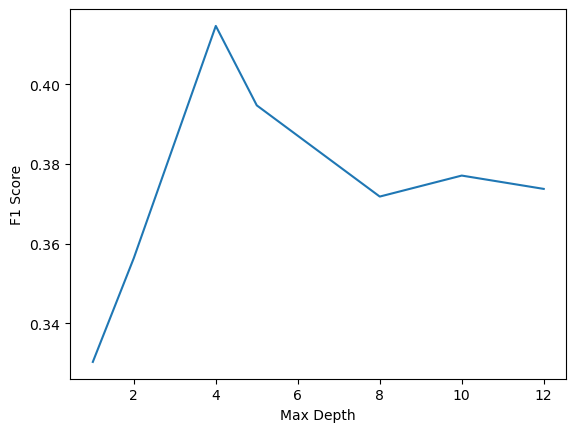

In [363]:
depths = [1, 2, 4, 5, 8, 10, 12]
y_pred_depth = []
for depth in depths:
    model = GradientBoostingClassifier(max_depth=depth).fit(X_norm, y_train)
    y_pred = model.predict(X_norm_test)
    y_pred_depth.append(f1_score(y_test, y_pred, average='macro'))

plt.plot(depths, y_pred_depth)
plt.ylabel('F1 Score')
plt.xlabel('Max Depth')
plt.show()

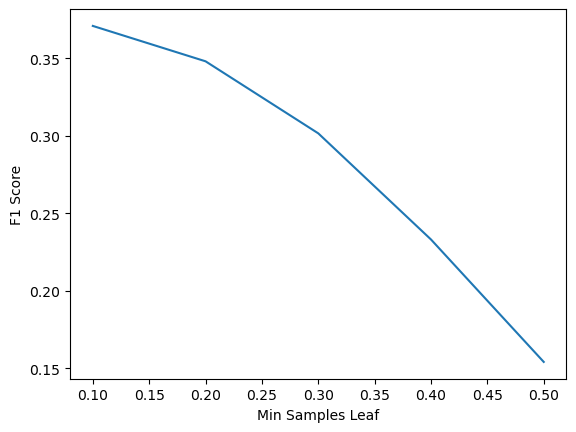

In [161]:
min_samples = np.linspace(0.1, 0.5, 5, endpoint=True)
y_pred_samples = []
for sample in min_samples:
    model = GradientBoostingClassifier(min_samples_leaf=sample).fit(X_norm, y_train)
    y_pred = model.predict(X_norm_test)
    y_pred_samples.append(f1_score(y_test, y_pred, average='macro'))

plt.plot(min_samples, y_pred_samples)
plt.ylabel('F1 Score')
plt.xlabel('Min Samples Leaf')
plt.show()

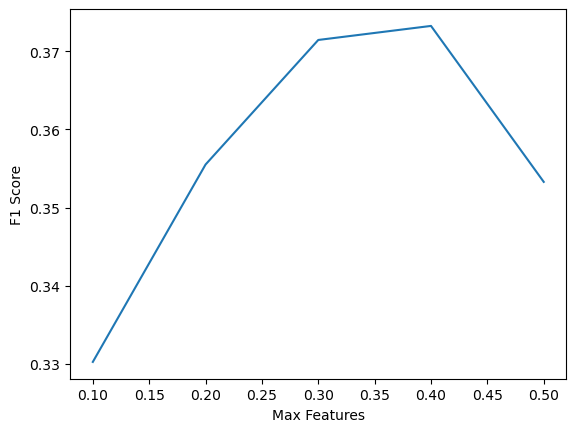

In [169]:
features = np.linspace(0.1, 0.5, 5, endpoint=True)
y_pred_feature = []
for feature in features:
    model = GradientBoostingClassifier(max_features=feature).fit(X_norm, y_train)
    y_pred = model.predict(X_norm_test)
    y_pred_feature.append(f1_score(y_test, y_pred, average='macro'))

plt.plot(features, y_pred_feature)
plt.ylabel('F1 Score')
plt.xlabel('Max Features')
plt.show()
# Attempted to set max features to 0.4 but got darastically reduced performance

In [364]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_depth=2, random_state=0).fit(X_norm, y_train)
y_forest = forest.predict(X_norm_test)

In [365]:
# Base Gradient boosted model is substantially better
print(accuracy_score(y_test, y_forest))
print(f1_score(y_test, y_forest, average='macro'))

0.627287853577371
0.15419222903885482
